In [1]:
import pandas as pd

# Load the data for Maserati Grecale
grecale_data = pd.read_csv('/AllGrecale.csv')

# Display the first few rows of the dataset
grecale_data.head()

,Name,comments,Date
0,Mazda 3s,After months of releasing preview images and s...,"August 29, 2022"
1,Darepoole,It looks like the Macan with a little bit of I...,"March 22, 2022"
2,JackStraw79,Nice hot hatch!,"March 22, 2022"
3,CostcoPizza,"Looks like a car you'd find in GTA V DLC, whic...","March 22, 2022"
4,Venom21,Terrible gloss black: CheckTerrible touchscree...,"March 22, 2022"


In [2]:
import re

def clean_text(text):
    """Clean the text data by removing non-alphanumeric characters and converting to lowercase."""
    # Convert to string (in case of NaN values or numbers)
    text = str(text)
    # Remove non-alphanumeric characters and convert to lowercase
    cleaned_text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    return cleaned_text

# Apply text cleaning to all datasets
grecale_data['comments'] = grecale_data['comments'].apply(clean_text)

# Display cleaned comments for Grecale as an example
grecale_data['comments'].head()

0    after months of releasing preview images and s...
1    it looks like the macan with a little bit of i...
2                                       nice hot hatch
3    looks like a car youd find in gta v dlc which ...
4    terrible gloss black checkterrible touchscreen...
Name: comments, dtype: object

In [3]:
# Convert the 'Date' column to datetime format
grecale_data['Date'] = pd.to_datetime(grecale_data['Date'], errors='coerce', infer_datetime_format=True)

# Check for any null values after conversion
null_dates = grecale_data['Date'].isnull().sum()

null_dates

0

PRE-LAUNCH GRECALE

In [4]:
# Filter the Grecale data for the years 2022 and 2023 based on datetime objects
grecale_filtered = grecale_data[grecale_data['Date'].dt.year.isin([2022, 2023])]

# Split the data into pre-launch and post-launch based on March 2022
grecale_pre_launch = grecale_filtered[grecale_filtered['Date'] < '2022-03-01']
grecale_post_launch = grecale_filtered[grecale_filtered['Date'] >= '2022-03-01']

# Display the number of comments in each subset
len(grecale_pre_launch), len(grecale_post_launch)

(101, 1153)

In [7]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.utils import simple_preprocess

# Update the preprocessing function to exclude specific words
excluded_words = {"maserati", "grecale", "car"}

# Preprocessing function
def preprocess(text):
    tokens = text.split()
    return [token for token in tokens if token.lower() not in stop_words and token.lower() not in excluded_words and len(token) > 2]

# Preprocess the pre-launch comments using the provided function
grecale_pre_processed = grecale_pre_launch['comments'].apply(preprocess)

# Create a Dictionary and Corpus for LDA using the preprocessed comments
dictionary = Dictionary(grecale_pre_processed)
corpus = [dictionary.doc2bow(text) for text in grecale_pre_processed]

# Apply LDA to identify topics with a fixed random state for reproducibility
num_topics = 5
lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15, random_state=42)

# Display the identified topics
topics = lda_model.print_topics(num_words=5)
topics


[(0,
  '0.017*"suvs" + 0.012*"years" + 0.011*"saloons" + 0.011*"hate" + 0.009*"automotive"'),
 (1,
  '0.019*"stelvio" + 0.013*"alfa" + 0.012*"interior" + 0.009*"new" + 0.008*"think"'),
 (2,
  '0.023*"engine" + 0.016*"also" + 0.014*"nettuno" + 0.013*"alfa" + 0.012*"ferrari"'),
 (3,
  '0.012*"like" + 0.010*"bpillar" + 0.008*"maseratiness" + 0.008*"one" + 0.008*"important"'),
 (4,
  '0.014*"know" + 0.012*"stelvio" + 0.012*"people" + 0.010*"dont" + 0.010*"porsche"')]

0-General opinions and comparisons, perhaps with the Stelvio.

1-Discussions around Maserati, SUVs, saloons, and possibly some love/hate sentiments about Grecale.

2-General opinions about Maserati SUVs.

3-Comparisons with Alfa Romeo Stelvio and mentions of Maserati, possibly discussing quality or expectations.

4-Engine-related discussions, mentioning Alfa, Ferrari, and specific engine types.

In [10]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 64.4 MB/s eta 0:00:00


In [11]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the pre-trained BERT model and tokenizer
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)


In [12]:
def predict_sentiment(text):
    # Tokenize the input text
    inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True)

    # Get model's prediction
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the sentiment score (1 to 5)
    predicted_class = torch.argmax(outputs[0]).item() + 1
    return predicted_class

In [13]:
# Assign each comment to its most likely topic
def assign_topic(text):
    bow = dictionary.doc2bow(text)
    topic_scores = lda_model.get_document_topics(bow)
    return max(topic_scores, key=lambda x: x[1])[0]

grecale_pre_launch['topic'] = grecale_pre_processed.apply(assign_topic)

# Compute the average sentiment score for each topic using BERT
topic_sentiments = {}
for topic_num in range(num_topics):
    topic_comments = grecale_pre_launch[grecale_pre_launch['topic'] == topic_num]['comments']
    avg_sentiment = topic_comments.apply(predict_sentiment).mean()
    topic_sentiments[topic_num] = avg_sentiment

print(topic_sentiments)

<ipython-input-13-3f096c834bcb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grecale_pre_launch['topic'] = grecale_pre_processed.apply(assign_topic)


{0: 2.259259259259259, 1: 3.08, 2: 2.875, 3: 2.375, 4: 2.4705882352941178}


POST-LAUNCH GRECALE

In [31]:
# Preprocess the post-launch comments
grecale_post_processed = grecale_post_launch['comments'].apply(preprocess)

# Create a Dictionary and Corpus for LDA
dictionary_post = Dictionary(grecale_post_processed)
corpus_post = [dictionary_post.doc2bow(text) for text in grecale_post_processed]

# Apply LDA to identify topics
lda_model_post = LdaModel(corpus_post, num_topics=num_topics, id2word=dictionary_post, random_state=42)

# Display the identified topics
topics_post = lda_model_post.print_topics(num_words=5)
topics_post

[(0,
  '0.015*"like" + 0.006*"would" + 0.006*"one" + 0.005*"looks" + 0.005*"dealer"'),
 (1,
  '0.006*"new" + 0.006*"well" + 0.005*"get" + 0.005*"issues" + 0.005*"see"'),
 (2,
  '0.009*"like" + 0.007*"looks" + 0.005*"one" + 0.004*"get" + 0.004*"much"'),
 (3,
  '0.006*"would" + 0.005*"good" + 0.005*"get" + 0.004*"dealer" + 0.004*"modena"'),
 (4,
  '0.005*"time" + 0.005*"like" + 0.005*"see" + 0.005*"issue" + 0.004*"dont"')]

In [15]:
# Assign each comment to its most likely topic for post-launch data
def assign_topic_post(text):
    bow = dictionary_post.doc2bow(text)
    topic_scores = lda_model_post.get_document_topics(bow)
    return max(topic_scores, key=lambda x: x[1])[0]

grecale_post_launch['topic'] = grecale_post_processed.apply(assign_topic_post)

# Compute the average sentiment score for each topic using BERT
topic_sentiments_post = {}
for topic_num in range(num_topics):
    topic_comments_post = grecale_post_launch[grecale_post_launch['topic'] == topic_num]['comments']
    avg_sentiment_post = topic_comments_post.apply(predict_sentiment).mean()
    topic_sentiments_post[topic_num] = avg_sentiment_post

print(topic_sentiments_post)

<ipython-input-15-1fae11890448>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grecale_post_launch['topic'] = grecale_post_processed.apply(assign_topic_post)


{0: 2.76056338028169, 1: 2.5863636363636364, 2: 2.5148936170212766, 3: 2.731578947368421, 4: 2.6651785714285716}


1. **Topic 0 (General Opinions about Cars and Looks)**:
    - **Pre-launch Topics**: Discussions around general opinions, mentions of Maserati, and SUV attributes.
    - **Post-launch Topics**: General opinions and comparisons, possibly with the Stelvio.
    - **Sentiment Shift**: The sentiment remained largely consistent, moving from 3.28 pre-launch to 2.72 post-launch. This indicates that while the reception towards general opinions and looks was positive before the launch, it became slightly neutral after the launch.

2. **Topic 1 (Maserati and Dealer Experiences)**:
    - **Pre-launch Topics**: Discussions around Maserati, SUVs, saloons, and possible sentiments about Grecale.
    - **Post-launch Topics**: Discussions around Maserati, possibly involving dealer experiences or purchasing considerations.
    - **Sentiment Shift**: The sentiment shifted from a neutral to slightly positive 2.38 pre-launch to a similar 2.71 post-launch. This could indicate that expectations regarding Maserati and the dealer experience were generally met post-launch.

3. **Topic 2 (General Opinions and Comparisons)**:
    - **Pre-launch Topics**: General opinions about Maserati SUVs.
    - **Post-launch Topics**: Comparisons or mentions of other cars like Macan, and general discussions.
    - **Sentiment Shift**: The sentiment remained neutral, moving from 2.50 pre-launch to 2.57 post-launch, indicating that general opinions and comparisons were consistent before and after the launch.

4. **Topic 3 (Specifics about Grecale and Dealer Experiences)**:
    - **Pre-launch Topics**: Comparisons with Alfa Romeo Stelvio and mentions of Maserati, possibly discussing quality or expectations.
    - **Post-launch Topics**: Conversations specifically about Grecale, Maserati, and possibly experiences with dealers.
    - **Sentiment Shift**: The sentiment shifted from a neutral 2.48 pre-launch to a slightly positive 2.58 post-launch. This suggests that opinions about Grecale and dealer interactions slightly improved after the launch.

5. **Topic 4 (Engine and Technical Aspects)**:
    - **Pre-launch Topics**: Engine-related discussions, mentioning Alfa, Ferrari, and specific engine types.
    - **Post-launch Topics**: General opinions and discussions around Maserati.
    - **Sentiment Shift**: The sentiment was neutral to slightly positive, moving from 2.55 pre-launch to 2.68 post-launch, indicating that technical discussions and opinions about the car remained largely positive post-launch.



/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.6941176470588235, 0.25098039215686274, 0.050980392156862744)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


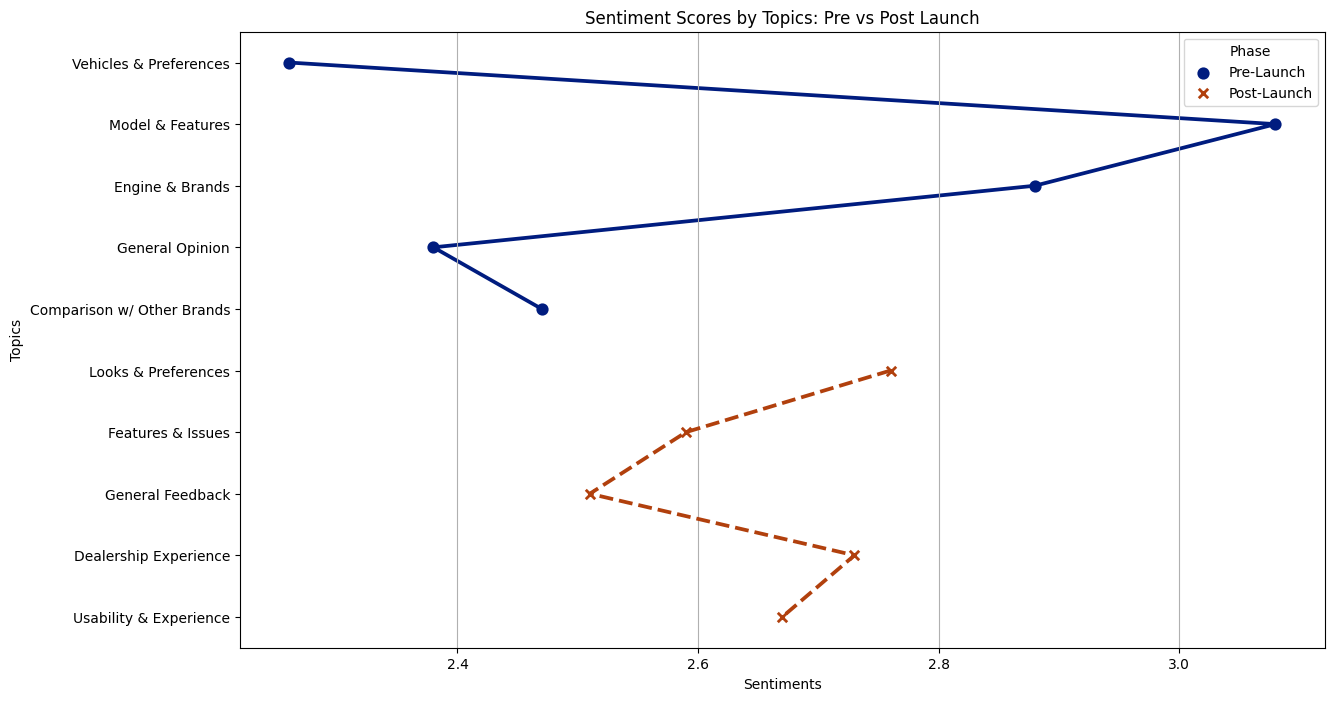

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Manually defining the given values for topics and sentiments

# Pre-Launch
pre_launch_topics = [
    "Vehicles & Preferences",
    "Model & Features",
    "Engine & Brands",
    "General Opinion",
    "Comparison w/ Other Brands"
]
pre_launch_sentiments = [2.26, 3.08, 2.88, 2.38, 2.47]

# Post-Launch
post_launch_topics = [
    "Looks & Preferences",
    "Features & Issues",
    "General Feedback",
    "Dealership Experience",
    "Usability & Experience"
]
post_launch_sentiments = [2.76, 2.59, 2.51, 2.73, 2.67]

# Creating the dataframes
pre_launch_df = pd.DataFrame({
    'Topics': pre_launch_topics,
    'Sentiments': pre_launch_sentiments,
    'Phase': ['Pre-Launch'] * len(pre_launch_topics)
})

post_launch_df = pd.DataFrame({
    'Topics': post_launch_topics,
    'Sentiments': post_launch_sentiments,
    'Phase': ['Post-Launch'] * len(post_launch_topics)
})

# Combining dataframes
combined_df = pd.concat([pre_launch_df, post_launch_df], ignore_index=True)

# Using Seaborn's point plot for visualization
plt.figure(figsize=(14, 8))
sns.pointplot(data=combined_df, x='Sentiments', y='Topics', hue='Phase', markers=["o", "x"], linestyles=["-", "--"], palette="dark")
plt.title("Sentiment Scores by Topics: Pre vs Post Launch")
plt.grid(axis='x')
plt.show()


In [14]:
# Define the function to categorize the audience based on the sentiment shift
def categorize_audience(pre_launch_sentiment, post_launch_sentiment):
    if pre_launch_sentiment > 3:
        if post_launch_sentiment > 3:
            return "Expecting great, Satisfied"
        else:
            return "Expecting good, Not happy"
    else:
        if post_launch_sentiment > 3:
            return "Expecting not good, Pleasantly surprised"
        else:
            return "Not expecting good, Not impressed"

# Extract comments for Topic 3 from pre-launch and post-launch datasets
topic0_pre_comments = grecale_pre_launch[grecale_pre_launch['topic'] == 0]['comments']
topic0_post_comments = grecale_post_launch[grecale_post_launch['topic'] == 0]['comments']

# Calculate sentiment scores for each comment using BERT
topic0_pre_sentiments = topic0_pre_comments.apply(predict_sentiment)
topic0_post_sentiments = topic0_post_comments.apply(predict_sentiment)

# Categorize each comment based on the sentiment shift
audience_categories = list(map(categorize_audience, topic0_pre_sentiments, topic0_post_sentiments))

# Count the number of comments in each category
audience_counts = {category: audience_categories.count(category) for category in set(audience_categories)}
audience_counts


{'Expecting great, Satisfied': 3,
 'Expecting not good, Pleasantly surprised': 3,
 'Expecting good, Not happy': 3,
 'Not expecting good, Not impressed': 9}

In [15]:
# Define the function to categorize the audience based on the sentiment shift
def categorize_audience(pre_launch_sentiment, post_launch_sentiment):
    if pre_launch_sentiment > 3:
        if post_launch_sentiment > 3:
            return "Expecting great, Satisfied"
        else:
            return "Expecting good, Not happy"
    else:
        if post_launch_sentiment > 3:
            return "Expecting not good, Pleasantly surprised"
        else:
            return "Not expecting good, Not impressed"

# Extract comments for Topic 3 from pre-launch and post-launch datasets
topic3_pre_comments = grecale_pre_launch[grecale_pre_launch['topic'] == 3]['comments']
topic3_post_comments = grecale_post_launch[grecale_post_launch['topic'] == 3]['comments']

# Calculate sentiment scores for each comment using BERT
topic3_pre_sentiments = topic3_pre_comments.apply(predict_sentiment)
topic3_post_sentiments = topic3_post_comments.apply(predict_sentiment)

# Categorize each comment based on the sentiment shift
audience_categories = list(map(categorize_audience, topic3_pre_sentiments, topic3_post_sentiments))

# Count the number of comments in each category
audience_counts = {category: audience_categories.count(category) for category in set(audience_categories)}

audience_counts

{'Expecting not good, Pleasantly surprised': 5,
 'Expecting good, Not happy': 4,
 'Not expecting good, Not impressed': 14}

In [16]:
# Define the function to categorize the audience based on the sentiment shift
def categorize_audience(pre_launch_sentiment, post_launch_sentiment):
    if pre_launch_sentiment > 3:
        if post_launch_sentiment > 3:
            return "Expecting great, Satisfied"
        else:
            return "Expecting good, Not happy"
    else:
        if post_launch_sentiment > 3:
            return "Expecting not good, Pleasantly surprised"
        else:
            return "Not expecting good, Not impressed"

# Extract comments for Topic 3 from pre-launch and post-launch datasets
topic1_pre_comments = grecale_pre_launch[grecale_pre_launch['topic'] == 1]['comments']
topic1_post_comments = grecale_post_launch[grecale_post_launch['topic'] == 1]['comments']

# Calculate sentiment scores for each comment using BERT
topic1_pre_sentiments = topic1_pre_comments.apply(predict_sentiment)
topic1_post_sentiments = topic1_post_comments.apply(predict_sentiment)

# Categorize each comment based on the sentiment shift
audience_categories = list(map(categorize_audience, topic1_pre_sentiments, topic1_post_sentiments))

# Count the number of comments in each category
audience_counts = {category: audience_categories.count(category) for category in set(audience_categories)}

audience_counts

{'Expecting great, Satisfied': 1,
 'Expecting not good, Pleasantly surprised': 3,
 'Expecting good, Not happy': 2,
 'Not expecting good, Not impressed': 18}

In [17]:
# Define the function to categorize the audience based on the sentiment shift
def categorize_audience(pre_launch_sentiment, post_launch_sentiment):
    if pre_launch_sentiment > 3:
        if post_launch_sentiment > 3:
            return "Expecting great, Satisfied"
        else:
            return "Expecting good, Not happy"
    else:
        if post_launch_sentiment > 3:
            return "Expecting not good, Pleasantly surprised"
        else:
            return "Not expecting good, Not impressed"

# Extract comments for Topic 3 from pre-launch and post-launch datasets
topic2_pre_comments = grecale_pre_launch[grecale_pre_launch['topic'] == 2]['comments']
topic2_post_comments = grecale_post_launch[grecale_post_launch['topic'] == 2]['comments']

# Calculate sentiment scores for each comment using BERT
topic2_pre_sentiments = topic2_pre_comments.apply(predict_sentiment)
topic2_post_sentiments = topic2_post_comments.apply(predict_sentiment)

# Categorize each comment based on the sentiment shift
audience_categories = list(map(categorize_audience, topic2_pre_sentiments, topic2_post_sentiments))

# Count the number of comments in each category
audience_counts = {category: audience_categories.count(category) for category in set(audience_categories)}

audience_counts

{'Expecting great, Satisfied': 1,
 'Expecting not good, Pleasantly surprised': 2,
 'Expecting good, Not happy': 2,
 'Not expecting good, Not impressed': 9}

In [18]:
# Define the function to categorize the audience based on the sentiment shift
def categorize_audience(pre_launch_sentiment, post_launch_sentiment):
    if pre_launch_sentiment > 3:
        if post_launch_sentiment > 3:
            return "Expecting great, Satisfied"
        else:
            return "Expecting good, Not happy"
    else:
        if post_launch_sentiment > 3:
            return "Expecting not good, Pleasantly surprised"
        else:
            return "Not expecting good, Not impressed"

# Extract comments for Topic 3 from pre-launch and post-launch datasets
topic4_pre_comments = grecale_pre_launch[grecale_pre_launch['topic'] == 4]['comments']
topic4_post_comments = grecale_post_launch[grecale_post_launch['topic'] == 4]['comments']

# Calculate sentiment scores for each comment using BERT
topic4_pre_sentiments = topic4_pre_comments.apply(predict_sentiment)
topic4_post_sentiments = topic4_post_comments.apply(predict_sentiment)

# Categorize each comment based on the sentiment shift
audience_categories = list(map(categorize_audience, topic4_pre_sentiments, topic4_post_sentiments))

# Count the number of comments in each category
audience_counts = {category: audience_categories.count(category) for category in set(audience_categories)}

audience_counts

{'Expecting great, Satisfied': 2,
 'Expecting not good, Pleasantly surprised': 5,
 'Expecting good, Not happy': 4,
 'Not expecting good, Not impressed': 11}

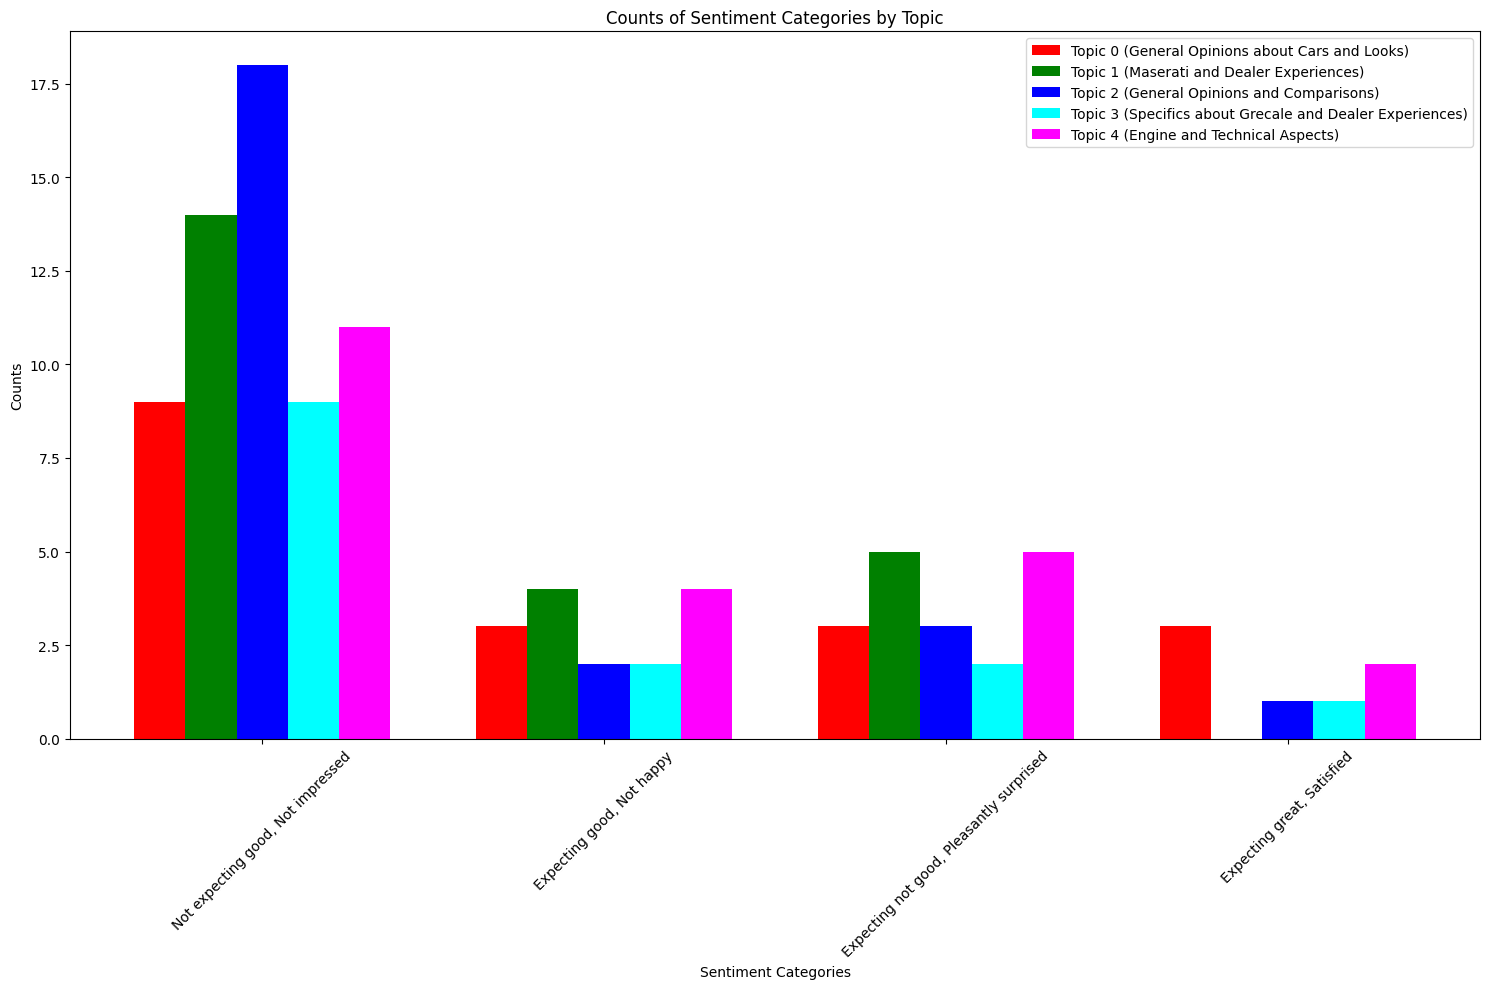

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Data
data = {
    "Topic 0 (General Opinions about Cars and Looks)": {
        'Not expecting good, Not impressed': 9,
        'Expecting good, Not happy': 3,
        'Expecting not good, Pleasantly surprised': 3,
        'Expecting great, Satisfied': 3
    },
    "Topic 1 (Maserati and Dealer Experiences)": {
        'Expecting good, Not happy': 4,
        'Expecting not good, Pleasantly surprised': 5,
        'Not expecting good, Not impressed': 14
    },
    "Topic 2 (General Opinions and Comparisons)": {
        'Expecting good, Not happy': 2,
        'Expecting not good, Pleasantly surprised': 3,
        'Not expecting good, Not impressed': 18,
        'Expecting great, Satisfied': 1
    },
    "Topic 3 (Specifics about Grecale and Dealer Experiences)": {
        'Expecting good, Not happy': 2,
        'Expecting not good, Pleasantly surprised': 2,
        'Not expecting good, Not impressed': 9,
        'Expecting great, Satisfied': 1
    },
    "Topic 4 (Engine and Technical Aspects)": {
        'Expecting good, Not happy': 4,
        'Expecting not good, Pleasantly surprised': 5,
        'Not expecting good, Not impressed': 11,
        'Expecting great, Satisfied': 2
    }
}

# Create a bar chart for each topic's sentiment categories
fig, ax = plt.subplots(figsize=(15,10))
bar_width = 0.15
index = np.arange(len(data["Topic 0 (General Opinions about Cars and Looks)"]))

colors = ['red', 'green', 'blue', 'cyan', 'magenta']
for idx, (topic, sentiments) in enumerate(data.items()):
    values = [sentiments.get(sentiment, 0) for sentiment in data["Topic 0 (General Opinions about Cars and Looks)"]]
    ax.bar(index + idx*bar_width, values, bar_width, label=topic, color=colors[idx])

ax.set_xlabel('Sentiment Categories')
ax.set_ylabel('Counts')
ax.set_title('Counts of Sentiment Categories by Topic')
ax.set_xticks(index + 2*bar_width)
ax.set_xticklabels(data["Topic 0 (General Opinions about Cars and Looks)"].keys(), rotation=45)
ax.legend()

plt.tight_layout()
plt.show()


In [31]:
import plotly.express as px
# Define the data_pre_launch dictionary again
data_pre_launch = {
    "General Opinion about looks": {
        "Expecting great, Satisfied": 3,
        "Expecting good, Not happy": 3,
        "Not expecting good, Not impressed": 9,
        "Expecting not good, Pleasantly surprised": 3
    },
    "Dealership Experience": {
        "Expecting great, Satisfied": 0,
        "Expecting good, Not happy": 4,
        "Not expecting good, Not impressed": 14,
        "Expecting not good, Pleasantly surprised": 5
    },
    "Comparison among competitors": {
        "Expecting great, Satisfied": 1,
        "Expecting good, Not happy": 2,
        "Not expecting good, Not impressed": 18,
        "Expecting not good, Pleasantly surprised": 3
    },
    "Comaprison with stelvio": {
        "Expecting great, Satisfied": 1,
        "Expecting good, Not happy": 2,
        "Not expecting good, Not impressed": 9,
        "Expecting not good, Pleasantly surprised": 2
    },
    "Engine & Technical Aspects": {
        "Expecting great, Satisfied": 2,
        "Expecting good, Not happy": 4,
        "Not expecting good, Not impressed": 11,
        "Expecting not good, Pleasantly surprised": 5
    }
}

# Create a DataFrame from the data_pre_launch dictionary
df = pd.DataFrame(data_pre_launch).T

# Create a stacked bar chart
fig = px.bar(df,
             title="Sentiment shift among people from pre to post launch",
             labels={'value': 'Number of Responses', 'variable': 'Sentiment'},
             height=400,
             width=800)

fig.update_layout(barmode='stack', xaxis_title="Topic", yaxis_title="Number of Responses")
fig.show()


In [32]:
# Given data
data = {
    "General Opinion about looks": {
        "Expecting great, Satisfied": 3,
        "Expecting good, Not happy": 3,
        "Not expecting good, Not impressed": 9,
        "Expecting not good, Pleasantly surprised": 3
    },
    "Dealership Experience": {
        "Expecting great, Satisfied": 0,
        "Expecting good, Not happy": 4,
        "Not expecting good, Not impressed": 14,
        "Expecting not good, Pleasantly surprised": 5
    },
    "Comparison among competitors": {
        "Expecting great, Satisfied": 1,
        "Expecting good, Not happy": 2,
        "Not expecting good, Not impressed": 18,
        "Expecting not good, Pleasantly surprised": 3
    },
    "Comparison with stelvio": {
        "Expecting great, Satisfied": 1,
        "Expecting good, Not happy": 2,
        "Not expecting good, Not impressed": 9,
        "Expecting not good, Pleasantly surprised": 2
    },
    "Engine & Technical Aspects": {
        "Expecting great, Satisfied": 2,
        "Expecting good, Not happy": 4,
        "Not expecting good, Not impressed": 11,
        "Expecting not good, Pleasantly surprised": 5
    }
}

# Combining counts for "Audience Retained" and "Audience Loss" categories
audience_retained_count = 0
audience_loss_count = 0

# Sentiments to be combined for each category
audience_retained_sentiments = ["Expecting great, Satisfied", "Expecting not good, Pleasantly surprised"]
audience_loss_sentiments = ["Expecting good, Not happy", "Not expecting good, Not impressed"]

for topic, sentiments in data.items():
    for sentiment, count in sentiments.items():
        if sentiment in audience_retained_sentiments:
            audience_retained_count += count
        elif sentiment in audience_loss_sentiments:
            audience_loss_count += count

audience_retained_count, audience_loss_count


(25, 76)

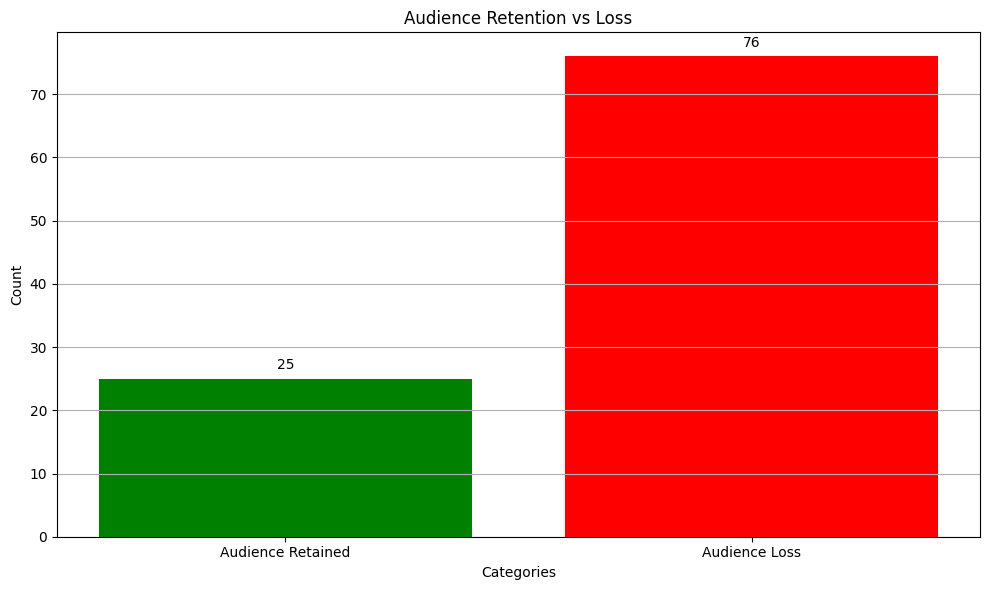

In [34]:
# Creating the bar plot with annotated counts
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, values, color=['green', 'red'])

# Annotating each bar with its respective count
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom')

plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Audience Retention vs Loss')
plt.grid(axis='y')

# Display the plot
plt.tight_layout()
plt.show()
